# HyperSpy Fitting tutorial

This tutorial shows the basics of model (currently only 1D) fitting in HyperSpy from the grounds up. All data is artificial and can be generated by running the code <a href='#two_peaks'>at the end</a> of the notebook.

__Required version:__

    HyperSpy 1.6

## Author:

- 13/04/2015 Tomas Ostasevicius - Developed for HyperSpy workshop at University of Cambridge
- 01/06/2016 Tomas Ostasevicius - updated and expanded for HyperSpy workshop at Scandem conference 2016
- 22/07/2016 Tomas Ostasevicius - updated for HyperSpy version 1.0
- 09/05/2019 Andrew Herzing and Joshua Taillon - Modified for NIST Hyperspy Tutorial
- 30/07/2021 Eric Prestat - Minor update for the M&M 2021 Sunday short course

<a id='top'></a>
## Contents:


1. General:
    - <a href='#terms'>The HyperSpy model - component - parameter relationship</a> 
    - <a href='#importing'>Importing HyperSpy</a> 
1. For fitting
  1. Data -> Model
      - <a href='#loading'>Loading a dataset</a>
      - <a href='#creating_model'>Creating a model</a>
  1. Components
      - <a href='#creating_components'>Creating components</a>
      - <a href='#adding_comps'>Adding components to a model</a>
      - <a href='#renaming_components'>Renaming components</a>   
  1. Parameters and values
      - <a href='#checking_values'>Displaying parameter values</a>
      - <a href='#setting_values'>Setting parameter values</a>
      - <a href='#adjust_position'>Adjustin positions of peaks with a mouse</a>   
  1. Fitting
      - <a href='#fit'>Fitting a single signal</a>
      - <a href='#multifit'>Fitting multiple spectra</a>    
  1. After fit
      - <a href='#plot_components'>Plotting individual components</a>
      - <a href='#plot_parameter'>Plotting parameter maps</a>
      - <a href='#statistics'>Statistical analysis of fitting results</a>
1. (Slightly more) Advanced:
    - <a href='#expression'>Writing your own components</a>
1. Addendum: Generating the synthetic data:
    - <a href='#two_peaks'>Two peaks</a>
    - <a href='#wobbly_peak'>Wobbly peak</a>

<a id='terms'></a>
### Terminology and relationships
<a href='#top'>[back to top]</a> 

In order to use fitting in HyperSpy more effectively, it is useful to understand our structure for curve fitting.

There are three main things, related to fitting:

__1. Model__
can be thought of as a simple box (cooking pot), where we have to put our ingredients. Without anything inside, it is not of much use in this case. Once we add some things to it and mix it a bit (do the actual fitting), however, we have our complete dish!

__2. Component__ is the main building block (ingredient) of our model. Here we mix and match what components we need (or want) for the particular case of signal. 

Examples: 
- Lorentzian (Cauchy)
- Gaussian
- Voigt (a combination of Lorentzian and Gaussian)
- Offset (i.e. constant background)
- Exponential function
- ...
- [create your own or use the very specialised ones!]

Each of the components is ultimately just a function that has variables that change the (shape of the) output. Such a variable in HyperSpy is called a __parameter__


__3. Parameter__ is the knob that the fitting routine adjusts for a good fit. Each component must include at least one parameter in order to be able to change when fitting. A parameter is also the object that we may limit or have to adjust when the result of the fit is not satisfactory. 

Ultimately, a parameter is the only important thing, as far as the fitting is concerned - components are just smart and convenient boxes to combine parameters into functions, and a model is just a box for a collection of components.

For now, let's just keep the rough structure in our heads and look at other things!



<a id='importing'></a>
### Importing
<a href='#top'>[back to top]</a> 

HyperSpy, like many other Python libraries, first has to be imported in your Python setup in order to be used.
Once it is, all the relevant commands can be looped up using the autocompletion feature of the IPython. 

Lets import the HyperSpy and set up plotting.

In [1]:
# set the plotting backend and import the required libraries
%matplotlib notebook
import hyperspy.api as hs
import matplotlib.pyplot as plt

<a id='loading'></a>
### Fitting in HyperSpy (detailed)
<a href='#top'>[back to top]</a> 

First you should have a spectrum (a particular kind of the `Signal` subclass!) you want to fit. Let's load a synthetic dataset with some curves named `"two_peaks.hspy"` and have a look at it.


In [2]:
# load the signal contained in "data/two_peaks.hspy"
s = hs.load("data/two_peaks.hspy")

In [3]:
# print out the contents of s
s

<Signal1D, title: Two gaussians, dimensions: (|1024)>

<IPython.core.display.Javascript object>


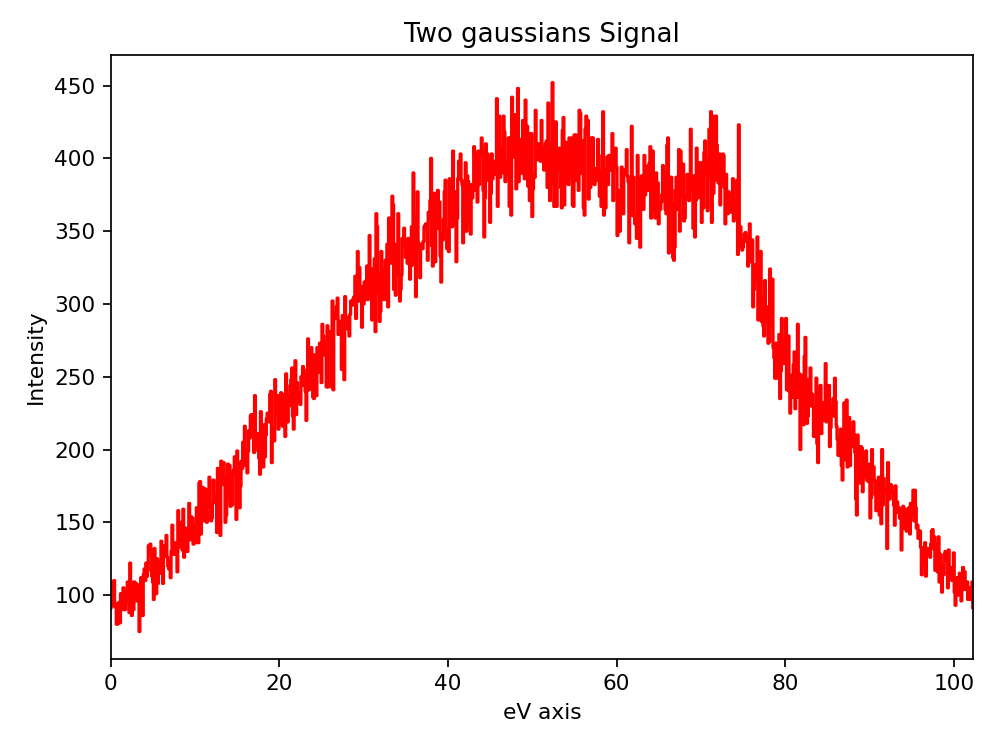

In [4]:
# plot the signal in s
s.plot()

<a id='creating_model'></a>
<a href='#top'>[back to top]</a> 

Creating a model now is simple - just pass the spectrum to the function 
> `model_reference = signal_reference.create_model()`

Let's reference the model by "`m`".

In [5]:
# create a model from the s and store it in m
m = s.create_model()

Let's look what's inside:

In [6]:
# inspect the components of the model
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

As we can see, the model is still empty. That will not always be the case - for some types of signals, an automatic background component is added when creating a model, hence it's always good to check.

We can plot the model in exactly the same way as the signal:

<IPython.core.display.Javascript object>


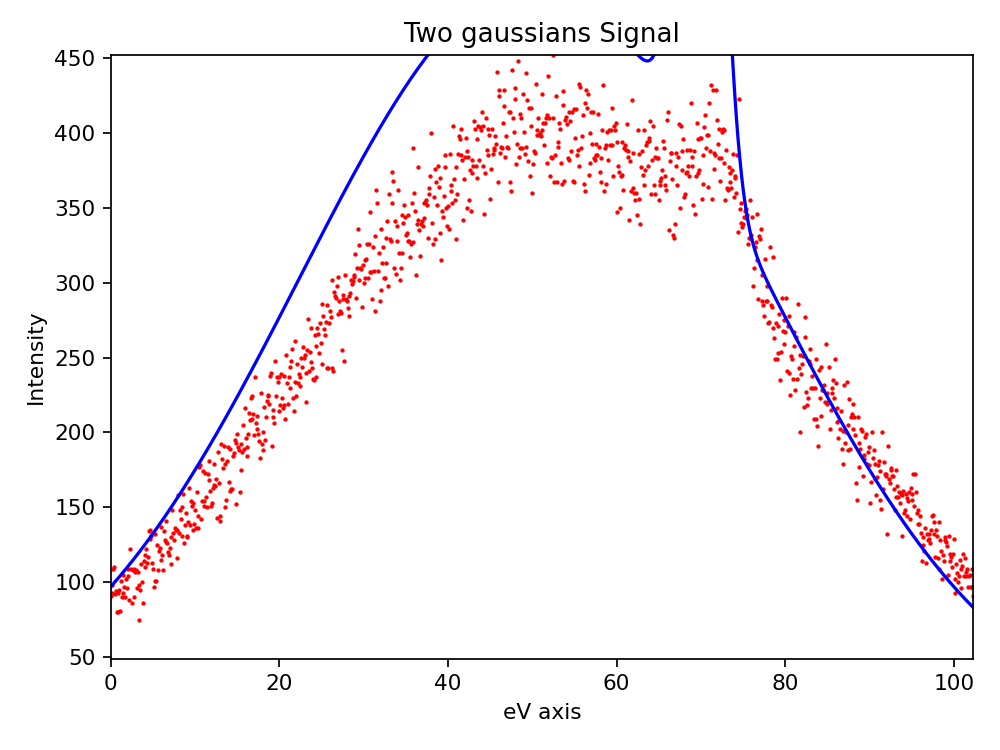

In [7]:
# plot the model
m.plot()

The only difference from the model plot is that each data point is displayed individually. 

<a id='creating_components'></a>
<a href='#top'>[back to top]</a> 

To do anything with the model, we should __create__ some __components__ and add them. Let's create two gaussians, referenced as "g1" and "g2". We are using the `GaussianHF` version, so we can build the component according to its full-width at half maximum, rather than centre and standard deviation:

-----------------
P.S.: keep in mind that creating a component is a function - hence there should be brackets at the end! Such as 

`our_component_reference = hs.model.components1D.example_component()`

In [8]:
# Create two GaussianHF components and give some sensible defaults
g1 = hs.model.components1D.GaussianHF(height=400, centre=50.0, fwhm=60)
g2 = hs.model.components1D.GaussianHF(height=30, centre=70, fwhm=5)

<a id='adding_comps'></a>
<a href='#top'>[back to top]</a> 

... and __add the components to__ our __model__. For that there are generally two ways:

Individually
> `our_model_reference.append(our_component_reference)`

or in lists (i.e. grouped by square brackets)
> `our_model_reference.extend([first_component_reference, second_component_reference])`

In [9]:
# add the components to the model
m.extend([g1, g2])

Let's check how the model looks now:

In [10]:
# print the contents of the model
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |          GaussianHF |          GaussianHF |          GaussianHF
   1 |        GaussianHF_0 |        GaussianHF_0 |          GaussianHF

<a id='renaming_components'></a>
<a href='#top'>[back to top]</a> 

For our convenience we can __rename__ the __components__ as we choose, for example "large" and "small" (note that the "g1" and "g2" are only references we created for them, not names of the components)

In [11]:
# rename the components 'large' and 'small'
g1.name = "large"
g2.name = "small"

We can look at the model again to see the result

In [12]:
# inspect the model components again
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               large |               large |          GaussianHF
   1 |               small |               small |          GaussianHF

<a id='checking_values'></a>
<a href='#top'>[back to top]</a>

To finally see the full structure, we can __print all of the parameter values__ of all components of the model.

In [13]:
# print the model's current values
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,50,,,
fwhm,True,60,,0,
height,True,400,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,70,,,
fwhm,True,5,,0,
height,True,30,,0,


To access the values, we have to look inside the components for the parameters. It can simply be done by following the pattern:
> `some_component_reference.parameter_name.value`

In this case the component references are the __g1__ and __g2__, while parameter names are ``centre``, ``height`` and ``fwhm``.

In [14]:
# inspect g1's FWHM value
g1.fwhm.value

60.0

<a id='setting_values'></a>
<a href='#top'>[back to top]</a>

We can __set parameter values__ in exactly the same way. Let set `g1` `fwhm` value to 65:

In [15]:
# set g1's FWHM value to 65
g1.fwhm.value = 65

In [16]:
# print the model's current values again
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,50,,,
fwhm,True,65,,0,
height,True,400,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,70,,,
fwhm,True,5,,0,
height,True,30,,0,


For convenience, we can also __set values "in bulk"__ for all components in the model. The required command is
> `m.set_parameters_value`

Set the height ("`height`" parameter) of both peaks to 500:

In [17]:
# set the value of all the model's components' height parameter to 500
m.set_parameters_value('height', 500)

In [18]:
# print the model's current values again
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,50,,,
fwhm,True,65,,0,
height,True,500,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,70,,,
fwhm,True,5,,0,
height,True,500,,0,


<a id='adjust_position'></a>
<a href='#top'>[back to top]</a>

When using HyperSpy in a notebook (like this one), we can also use additional interactive functions to adjust parameters with a mouse.

In order to enable it, call __`.gui()`__ for either model, component or parameter directly:

<IPython.core.display.Javascript object>


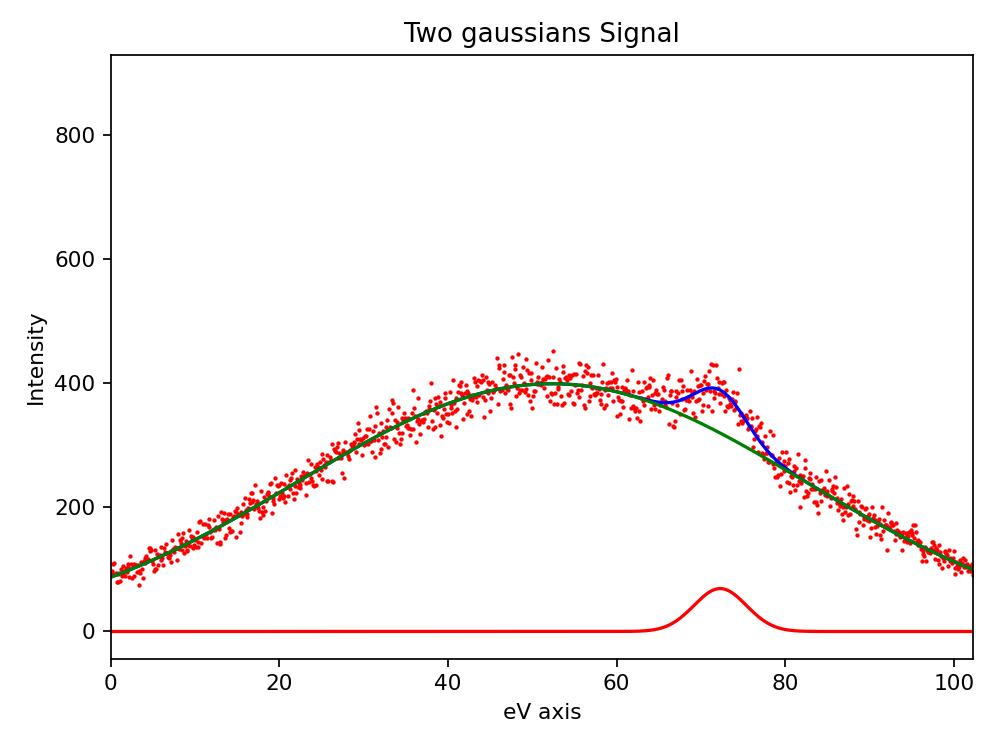

In [19]:
# Plot the model with its components
m.plot(True)

The small peak is much too large, so use the `.gui()` command to set the height of the small peak down to something more reasonable:

In [20]:
# Call the gui for the component in g2
g2.gui()

We'll set the small peak's height explicitly so everyone starts with the same initial conditions:

In [21]:
# set g2's height to 50
g2.height.value = 50

<a id='fit'></a>
<a href='#top'>[back to top]</a>

Finally, let's __fit__ the our __model__ and plot it afterwards to see how well (or poorly) we did

In [22]:
# fit the model
m.fit()

   covar: array([[ 6.07036334e-03,  8.25076472e-05,  1.36873940e-02,
        -4.14998386e-04, -8.08186769e-03, -3.72667804e-02],
       [ 8.25076472e-05,  3.61997412e-02, -1.42709128e-01,
        -3.29753090e-03,  5.25260031e-03,  3.23298659e-02],
       [ 1.36873940e-02, -1.42709128e-01,  1.31659538e+00,
         1.70961396e-02, -1.26777505e-01, -6.11113076e-01],
       [-4.14998386e-04, -3.29753090e-03,  1.70961396e-02,
         2.63876357e-02, -4.47985892e-03, -1.78459340e-03],
       [-8.08186769e-03,  5.25260031e-03, -1.26777505e-01,
        -4.47985892e-03,  1.61234259e-01, -5.91840163e-01],
       [-3.72667804e-02,  3.23298659e-02, -6.11113076e-01,
        -1.78459340e-03, -5.91840163e-01,  1.07541252e+01]])
     fun: array([-0.36349573, -0.51414365, -0.95428458, ...,  0.38191725,
       -0.84240136,  0.90683557])
 message: 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'
    nfev: 50
  status: 1
 success: True
       x: array([ 52.29

In [23]:
# print the model's current values again
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,52.2913,0.08148,,
fwhm,True,70.6626,0.198974,0,
height,True,399.548,1.19997,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,72.2873,0.169881,,
fwhm,True,7.32394,0.419925,0,
height,True,69.237,3.4295,0,


<IPython.core.display.Javascript object>


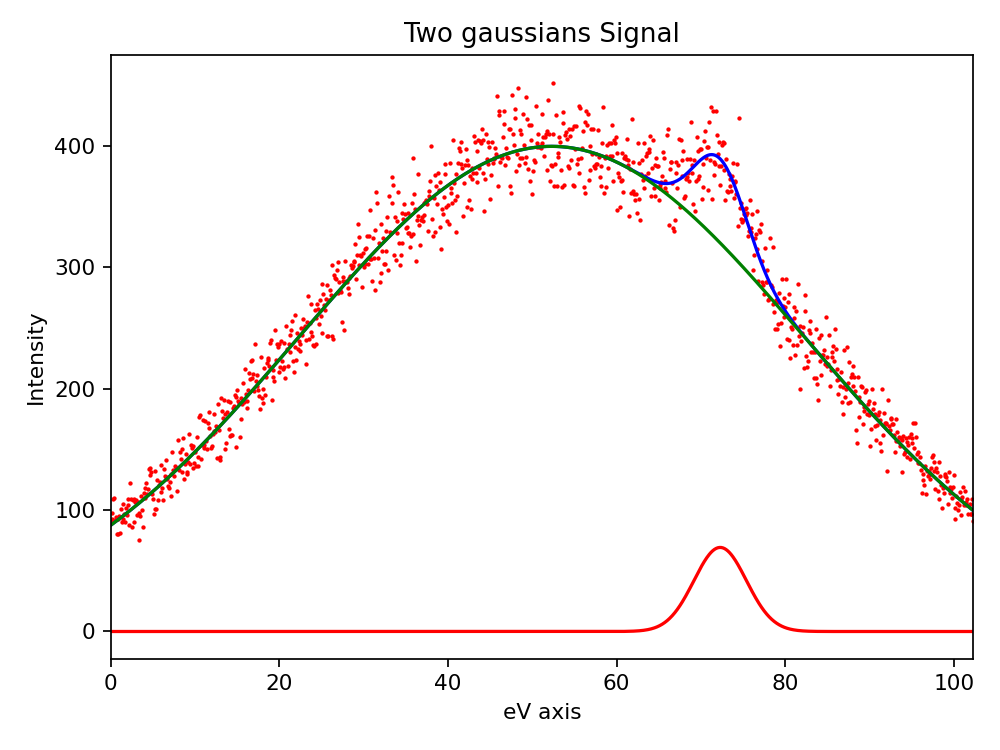

In [24]:
# plot the model after fitting with its components
m.plot(True)

<a id='multifit'></a>

Fitting a signal over the navigation axes
---------------------
<a href='#top'>[back to top]</a>

The above example demonstrates how a single `Signal` can be fit using different components, but the power of HyperSpy becomes truly evident when performing fits for larger datasets that vary over one or more navigation axis,
as is often the case for a collection of spectra (such as EELS or EDS)

We can fit all of them automatically (sequentially) using the `multifit()` method.

First load the spectrum `smoothly_moving_peaks.hspy`, reference  it as `s2` and create a new model for it `m2`:

In [25]:
# Load a spectrum image for curve fitting and create a model
s2 = hs.load('data/smoothly_moving_peaks.hspy')
m2 = s2.create_model()

We again create two components like we had in the previous part ( `g1` and `g2`), so let's add them to the new model and plot it to see what it looks like:

In [26]:
# Create two components and give them sensible defaults
g1 = hs.model.components1D.GaussianHF(height=400, centre=50, fwhm=60)
g2 = hs.model.components1D.GaussianHF(height=100, centre=85, fwhm=7)

# Rename the components
g1.name = "large"
g2.name = "small"

# Add them to the model
m2.extend([g1,g2])

<IPython.core.display.Javascript object>


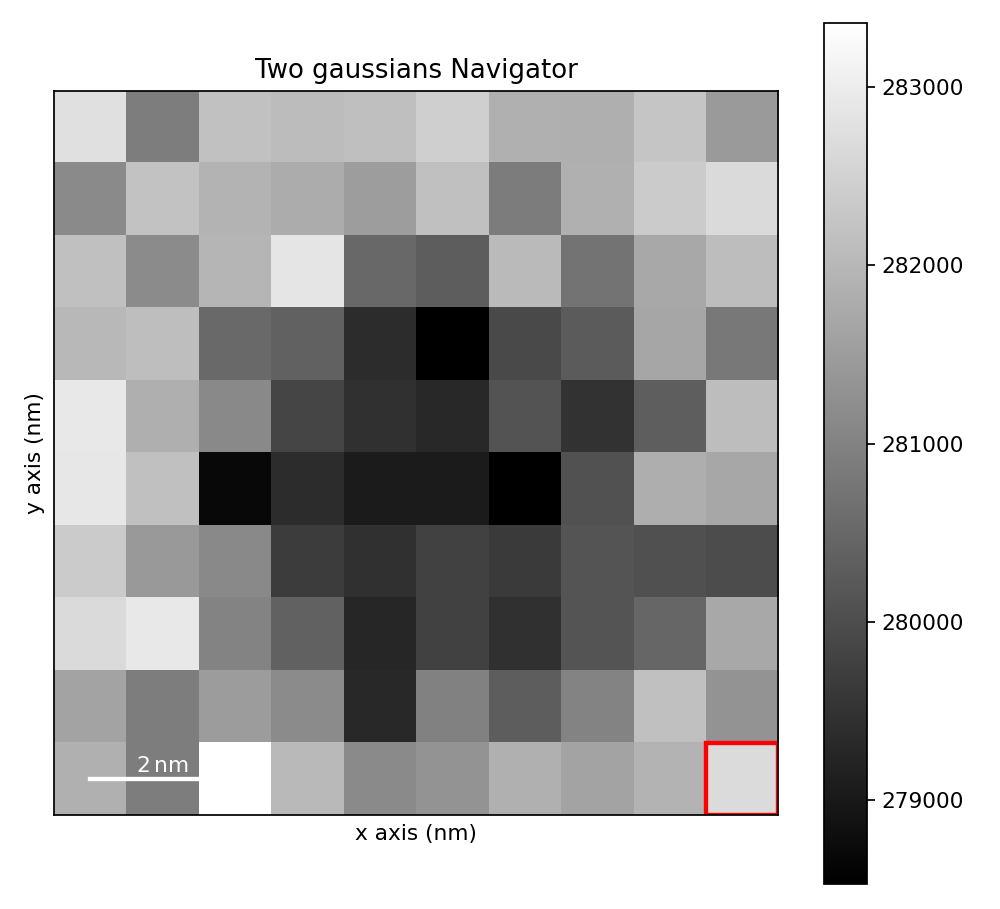

<IPython.core.display.Javascript object>


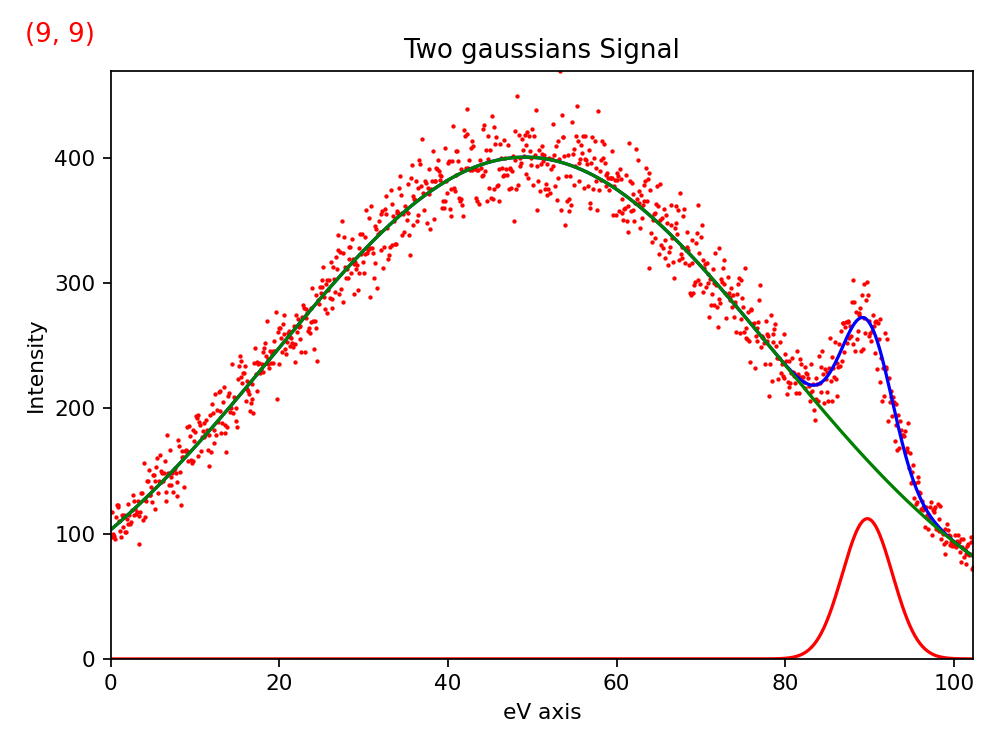

In [27]:
# Plot the model and its components
m2.plot(True)

If you drag the "spectrum picker" around the signal, you'll notice the values for the model are the same at every position, by default.

We will set the "current position" to the top left corner to ensure we always start the fit from the same position: 

In [28]:
# Set the position to (0, 0) so we start fitting from the top-left
m2.axes_manager[0].index = 0
m2.axes_manager[1].index = 0

We can see that the small peak is not where it should be, so we'll use the `fit()` command to fit the model for _just this pixel_. We use the "[Nelder-Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)" algorithm for the fitter (as implemented by [`scipy`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html)) since it is relatively performant, and appears to converge accurately for this system. A wide range of [fitter optimization algorithms](http://hyperspy.org/hyperspy-doc/current/user_guide/model.html#id3) are available thanks to the inclusion of `scipy`. 

Perform the fit for one pixel:

In [29]:
# Perform the fit for a single pixel
m2.fit(optimizer="Nelder-Mead")

 final_simplex: (array([[ 50.26395917,  70.6617219 , 399.11182865,  89.64883138,
          7.05707811, 106.81976162],
       [ 50.26396096,  70.66172509, 399.1117778 ,  89.64883082,
          7.05707482, 106.81982905],
       [ 50.26396171,  70.66172541, 399.11179036,  89.64882869,
          7.05707452, 106.81972994],
       [ 50.26396035,  70.6617192 , 399.1118221 ,  89.64882986,
          7.05707501, 106.81982847],
       [ 50.26395801,  70.66171994, 399.11181584,  89.64883138,
          7.05707723, 106.81977155],
       [ 50.26395814,  70.66171683, 399.11182973,  89.64883095,
          7.05708318, 106.81972164],
       [ 50.26395691,  70.66172106, 399.11180356,  89.64882775,
          7.05708142, 106.81979243]]), array([985.95400046, 985.95400046, 985.95400046, 985.95400046,
       985.95400046, 985.95400046, 985.95400046]))
           fun: 985.954000460837
       message: 'Optimization terminated successfully.'
          nfev: 580
           nit: 358
        status: 0
       succes

In [30]:
# print the model's current values
m2.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
centre,True,50.264,,,
fwhm,True,70.6617,,0,
height,True,399.112,,0,
Parameter Name,Free,Value,Std,Min,Max
centre,True,89.6488,,,
fwhm,True,7.05708,,0,
height,True,106.82,,0,


Now that we have a good fit for this pixel, we can use the `assign_current_values_to_all()` method to copy those values to all the navigation positions within the model. This is important, as the default values for the model may be wildly inaccurate, and cause the fitting algorithm to diverge (causing lots of headaches). 

We should also note that for Signals were the individual spectra vary widely between different parts of the data, this may not be an ideal fitting strategy, and a more manual approach may be needed.

Copy the values from this pixel to the rest of the signal:

In [31]:
# Copy the values from this pixel to the all the pixels in the signal
m2.assign_current_values_to_all()

Now we can perform a fit for all of the signals sequentially by passing command
> `m2.multifit()`

HyperSpy also has  an automatic routine ["SAMFire"](http://hyperspy.org/hyperspy-doc/current/user_guide/model.html#smart-adaptive-multi-dimensional-fitting-samfire) to do the fitting in a smarter way, utilizing parallel CPU processing and hence enabling much more complex models to be fitted even on non-superpowered systems, but it is not shown here.

The "`Nelder-Mead`" fitter is again used here:

In [32]:
# Fit the model over the whole spectrum image
m2.multifit(optimizer="Nelder-Mead")

/home/eric/Dev/hyperspy/hyperspy/model.py:1580: VisibleDeprecationWarning: The 'iterpath' default will change from 'flyback' to 'serpentine' in HyperSpy version 2.0. Change 'iterpath' to other than None to suppress this warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

<a id='plot_components'></a>
<a href='#top'>[back to top]</a>

We can see the total result of the fit by browsing around the now-fitted model:

<IPython.core.display.Javascript object>


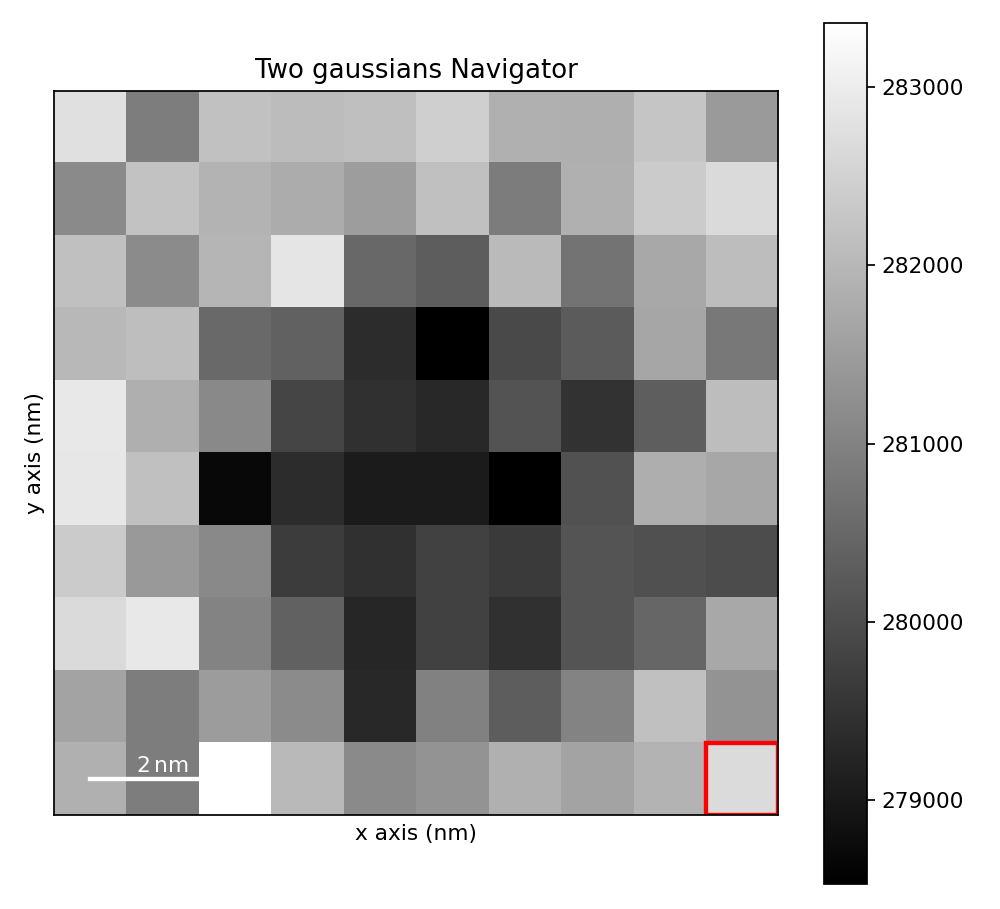

<IPython.core.display.Javascript object>


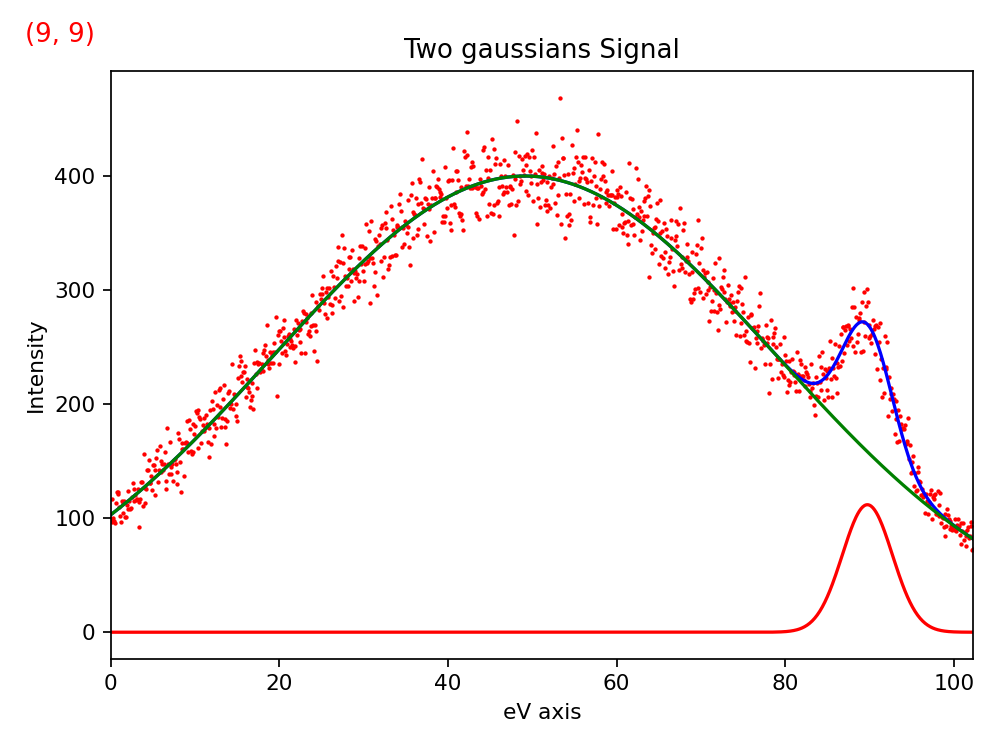

In [33]:
# Plot the model and its components
m2.plot(True)

<a id='plot_parameter'></a>
<a href='#top'>[back to top]</a>

Now that we have the artificial spectral image (SI) fitted, we can look at it however we want! For example, when fitting, you might have noticed that the position of the small peak shifted from pixel to pixel. We can __plot__ the centre __parameter__ of the component to have a look at it:

<IPython.core.display.Javascript object>


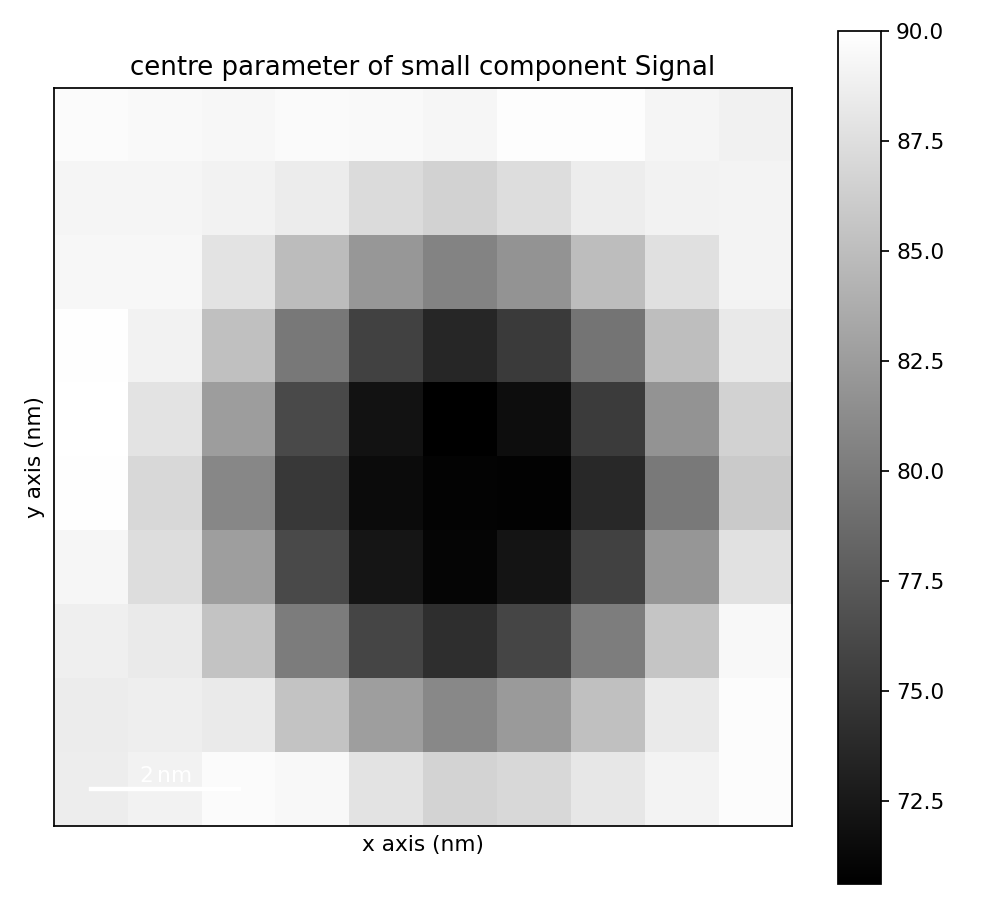

In [34]:
# Plot the values for the center of the small peak
g2.centre.plot()

We can use the `plot_images` method that was introduced in the previous topic to view all the parameters of the model. To use this, we have to convert each components' parameters into signals for plotting:

<IPython.core.display.Javascript object>


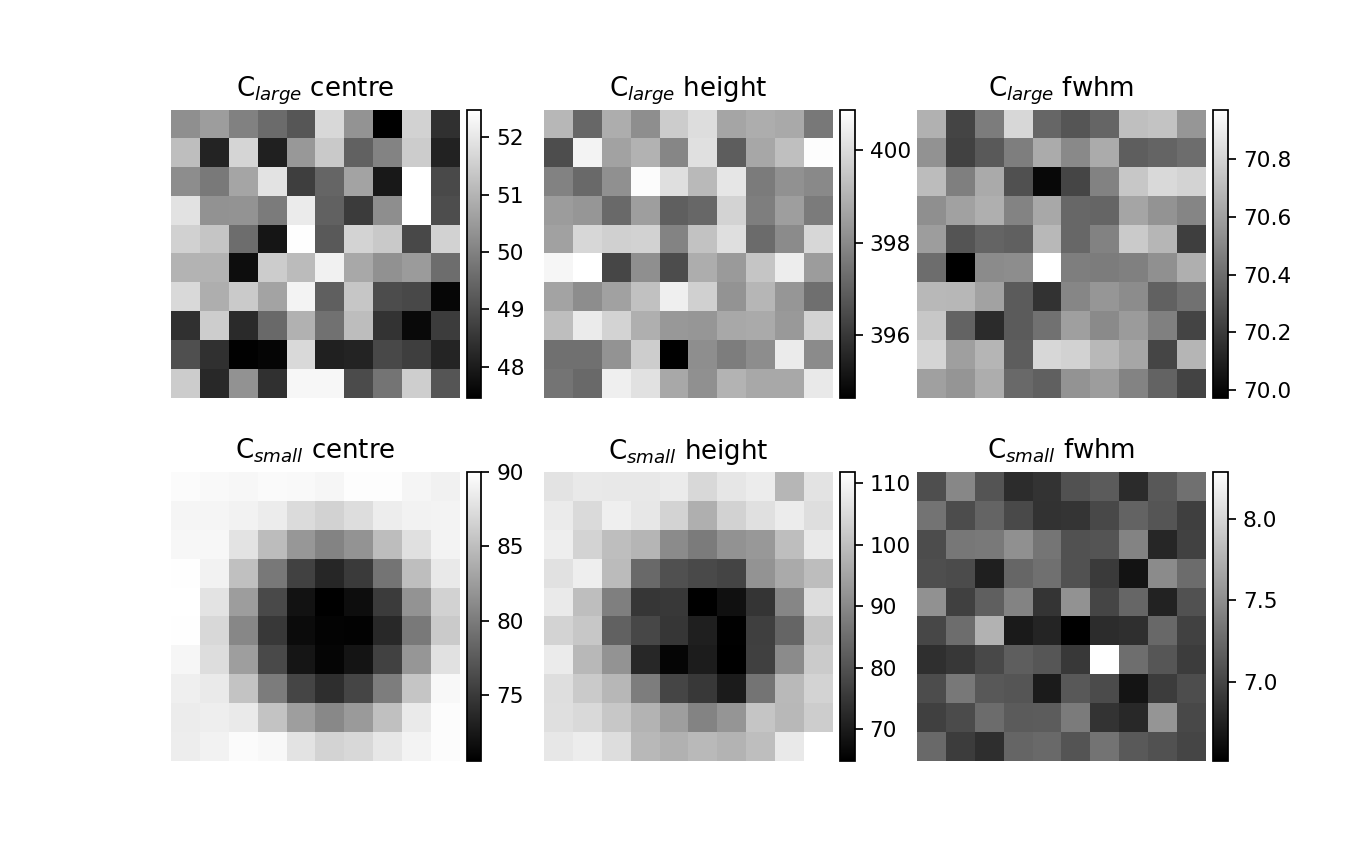

In [35]:
# Use plot_images to plot all the parameters' values
_ = hs.plot.plot_images([g1.centre.as_signal(), g1.height.as_signal(), g1.fwhm.as_signal(),
                         g2.centre.as_signal(), g2.height.as_signal(), g2.fwhm.as_signal()],
                        axes_decor='off',
                        label=['C$_{large}$ centre',
                               'C$_{large}$ height',
                               'C$_{large}$ fwhm',
                               'C$_{small}$ centre',
                               'C$_{small}$ height',
                               'C$_{small}$ fwhm'])

<a id='statistics'></a>

Statistical analysis of fitting results
---------------------
<a href='#top'>[back to top]</a>

Once the fit is performed, chi-squared ($\chi^2$), degrees of freedom, and reduced chi-squared of the fit are automatically calculated.

They are accessible with, respectively:
> `m2.chisq`

> `m2.dof`

> `m2.red_chisq`

Let's have a look at reduced $\chi^2$ by plotting it

<IPython.core.display.Javascript object>


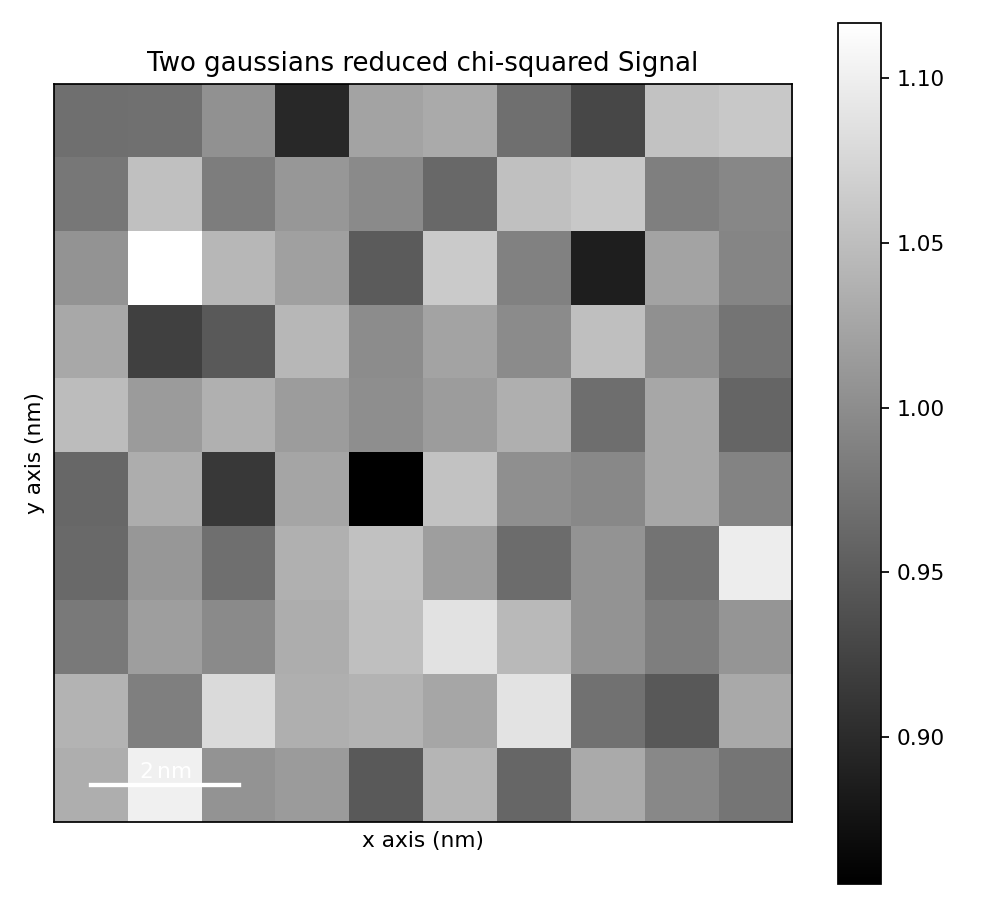

In [36]:
# Plot the reduced chi-squared value of the model
m2.red_chisq.plot()

We can see that the map looks relatively uniform (albeit with some noise, as expected). The colorbar scale tells us that all of the points fall in the (0.9, 1.15) range, which shows a good fit.

We can of course plot the histogram of the same data like so:

<IPython.core.display.Javascript object>


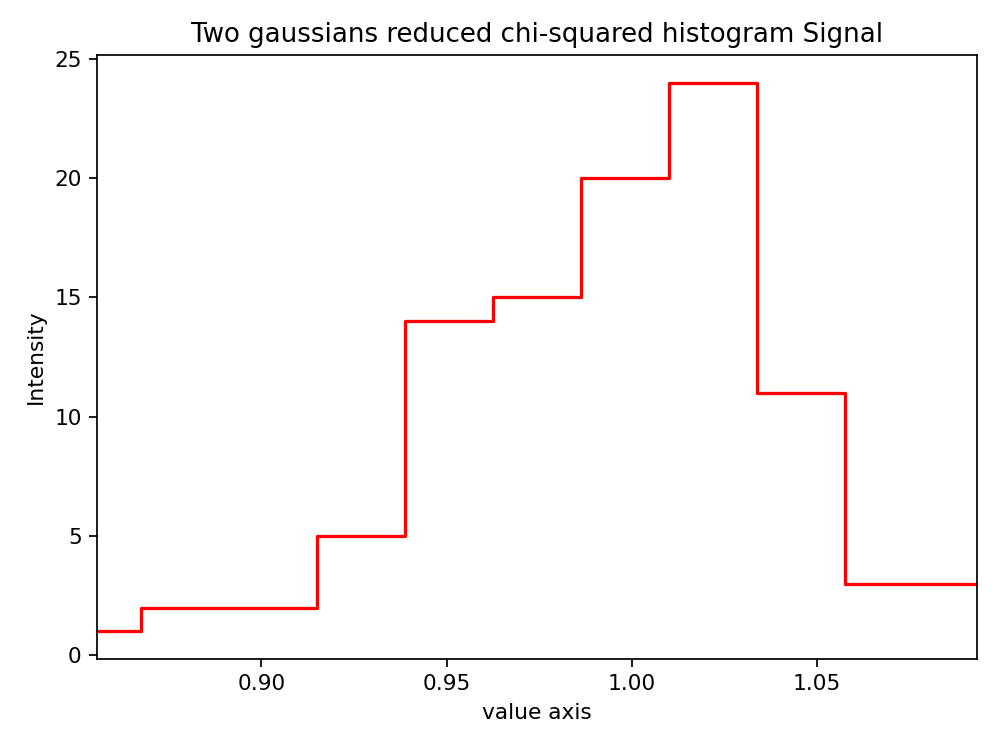

In [37]:
# Plot the histogram of the model's reduced chi-squared
m2.red_chisq.get_histogram().plot()

<a id='expression'></a>

Fitting with more interesting components
---------------------
<a href='#top'>[back to top]</a>



Lets say we have a slightly stranger signal that we want to fit, like this one:

In [38]:
# Load a signal that is a little more complicated than two Gaussians
s = hs.load('data/wobbly_peak.hspy')

<IPython.core.display.Javascript object>


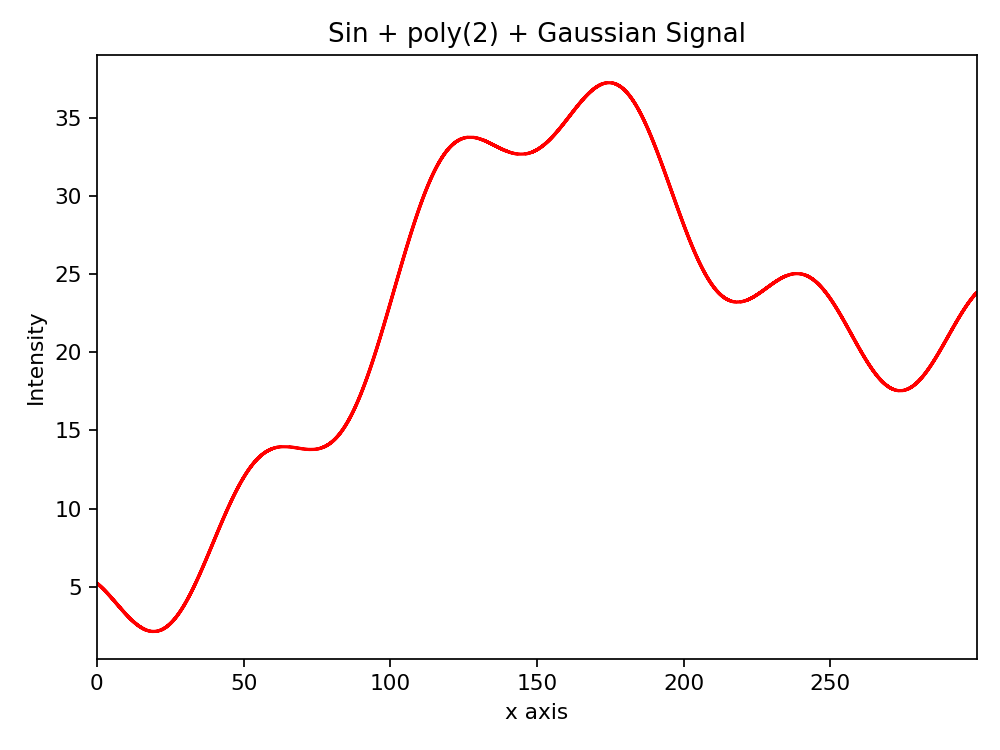

In [39]:
# Plot the signal
s.plot()

This `Signal` (as the name implies) is composed of a sinusoid + gaussian + 2<sup>nd</sup> degree polynomial. However we don't have a `sin` component in the in-built library, so we'll just write our own using the generic `Expression` class:

In [40]:
# Create a model component based off an arbitrary expression
sin = hs.model.components1D.Expression('A*sin(b*x + c)',
                                       name='sin')

Then we create and add all the additional components we might need: a gaussian and a polynomial (of second order):

In [41]:
# Create the model and add a Gaussian and polynomial component
m = s.create_model()
gaus = hs.model.components1D.GaussianHF()
poly = hs.model.components1D.Polynomial(order=2, legacy=False)

# Add the three components to the model
m.extend([sin, gaus, poly])

In [42]:
# print the model's initial values
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
A,True,0,,,
b,True,0,,,
c,True,0,,,
Parameter Name,Free,Value,Std,Min,Max
centre,True,0,,,
fwhm,True,1,,0,
height,True,1,,0,
Parameter Name,Free,Value,Std,Min,Max
a0,True,0,,,
a1,True,0,,,


The initial values do not seem to be very useful, so let's just plot the model, turn on the widgets, and we'll play until things seem close enough:

<IPython.core.display.Javascript object>


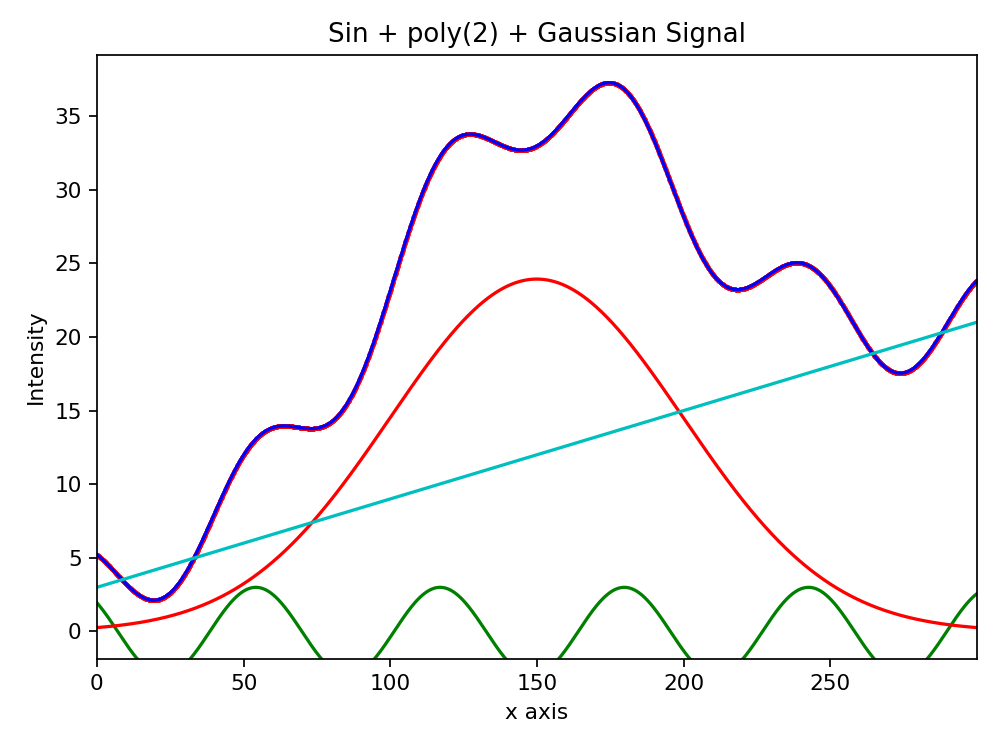

Accordion(children=(VBox(children=(Checkbox(value=True, description='active'), HBox(children=(FloatText(value=…

In [43]:
# Plot the model and bring up the interactive GUI
m.plot(True)
m.gui()

If you get lost in the GUI, here are some good starting parameters to use:

In [44]:
# Set some sensible starting values for the fit
m['sin'].A.value = -5
m['sin'].b.value = 0.1
m['sin'].c.value = 0.7

m['GaussianHF'].centre.value = 155.5
m['GaussianHF'].fwhm.value = 115.4
m['GaussianHF'].height.value = 35.4

m['2nd order Polynomial'].a0.value = 0.0
m['2nd order Polynomial'].a1.value = 0.08
m['2nd order Polynomial'].a2.value = 3

And then fit it and look at the results!

In [45]:
# Perform the fit
m.fit()

   covar: array([[ 7.02882924e-04,  1.33678564e-07, -1.80129990e-05,
        -4.69394397e-05,  1.14758499e-03,  1.69884041e-04,
        -2.06905366e-04, -1.57281761e-07,  1.07316086e-09],
       [ 1.33678564e-07,  1.00402848e-08, -1.49085660e-06,
         2.25899310e-07,  8.80483081e-06,  8.32111142e-07,
        -1.45675087e-06,  4.35076071e-09, -1.72595114e-11],
       [-1.80129990e-05, -1.49085660e-06,  2.95165055e-04,
         7.05458387e-05, -1.28467009e-03, -1.26663275e-04,
         2.62007479e-04, -8.65762323e-07,  2.06312100e-09],
       [-4.69394397e-05,  2.25899310e-07,  7.05458387e-05,
         1.58163716e-02, -8.04789919e-05, -8.38372473e-05,
         3.07432094e-03, -1.91679483e-05, -5.50759976e-09],
       [ 1.14758499e-03,  8.80483081e-06, -1.28467009e-03,
        -8.04789919e-05,  1.75428090e-01,  1.13310936e-02,
        -1.58681251e-02, -7.02862069e-05,  2.33853074e-07],
       [ 1.69884041e-04,  8.32111142e-07, -1.26663275e-04,
        -8.38372473e-05,  1.13310936e-02,

In [47]:
# print the model's current values
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max
A,True,-3,4.10027e-10,,
b,True,0.100033,1.54969e-12,,
c,True,-0.707963,2.65707e-10,,
Parameter Name,Free,Value,Std,Min,Max
centre,True,149.95,1.94502e-09,,
fwhm,True,117.702,6.47769e-09,0,
height,True,23.9365,1.07818e-09,0,
Parameter Name,Free,Value,Std,Min,Max
a0,True,3,9.96723e-10,,
a1,True,0.06002,1.07115e-11,,


<IPython.core.display.Javascript object>


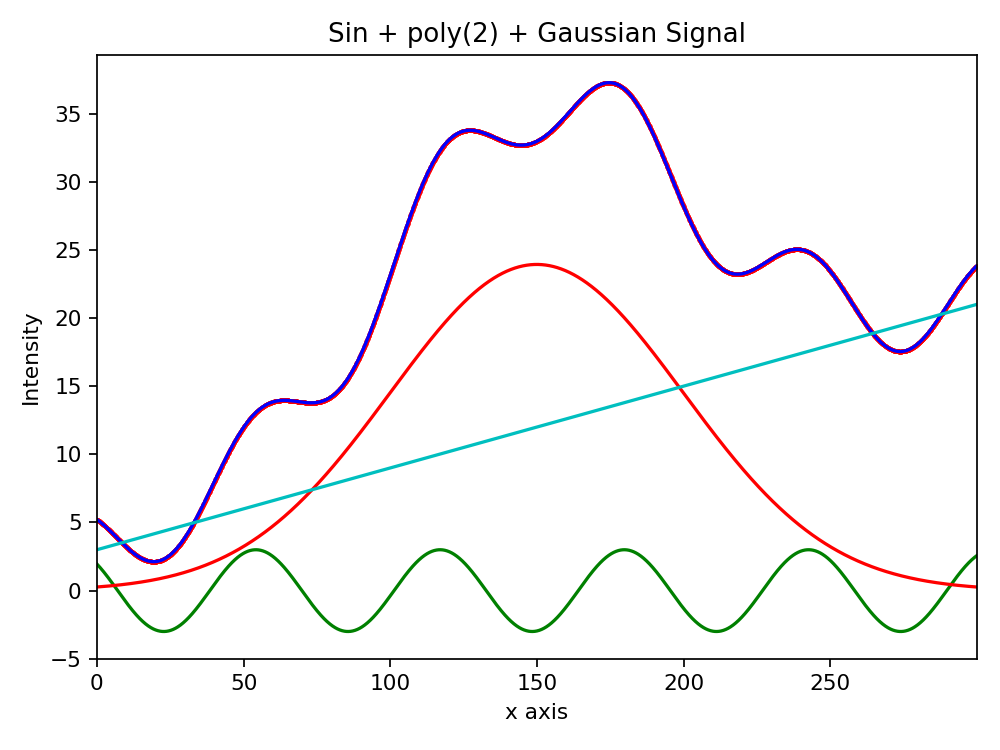

In [48]:
# Plot the model and its components
m.plot(True)

## Appendix: Generating synthetic data

<a id='two_peaks'></a>
### Two peaks
<a href='#top'>[back to top]</a> 


In [ ]:
from scipy.ndimage import gaussian_filter
import numpy as np
import hyperspy.api as hs
# set the parameters:
blurs = [0., 1.]
radius = 3  #radius of a different region
domain = 10 #size of the square domain
small_centres = (500, 900)
small_amplitudes = (8000,  5000)

# work:
total = None
cent = (domain//2, domain//2)
y,x = np.ogrid[-cent[0]:domain-cent[0], -cent[1]:domain-cent[1]]
mask = x*x + y*y <= radius*radius
for blur in blurs:

    s = hs.signals.Signal1D(np.ones((domain,domain, 1024)))
    cent = tuple([int(0.5*i) for i in s.data.shape[:-1]])
    m0 = s.create_model()
    gs01 = hs.model.components1D.Gaussian()
    m0.append(gs01)
    gs01.sigma.value = 300
    gs01.centre.map['values'][:] = (np.random.random((domain,domain)) - 0.5) * 50 + small_centres[0]
    gs01.centre.map['is_set'][:] = True
    gs01.A.map['values'][:] = 1000 * np.random.random((domain,domain)) + 300000
    gs01.A.map['is_set'][:] = True

    gs02 = hs.model.components1D.Gaussian()
    m0.append(gs02)
    gs02.sigma.value = 30
    gs02.centre.map['values'][:] = (np.random.random((domain,domain)) - 0.5) * 50 +  small_centres[1]

    gs02.centre.map['values'][mask] = (np.random.random(gs02.centre.map['values'][mask].shape) - 0.5) * 50 + 700
    #gs02.centre.map['values'][10:20,10:20] = (np.random.random((10,10)) - 0.5)*100 + 200

    gs02.centre.map['values'] = gaussian_filter(gs02.centre.map['values'], blur)
    gs02.centre.map['is_set'][:] = True
    gs02.A.map['values'][:] = small_amplitudes[0]
    gs02.A.map['values'][mask] = small_amplitudes[1]
    gs02.A.map['values'] = gaussian_filter(gs02.A.map['values'], blur)
    gs02.A.map['is_set'][:] = True
    s11 = m0.as_signal()
    if total is None:
        total = s11.data.copy()
    else:
        total = np.concatenate((total, s11.data), axis=1)

s = hs.signals.Signal1D(total)
s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Two gaussians'

s.add_poissonian_noise()
s.estimate_poissonian_noise_variance()
s.axes_manager[0].name = "x"
s.axes_manager[0].units = "nm"
s.axes_manager[1].name = "y"
s.axes_manager[1].units = "nm"

s.axes_manager[2].name = "Energy"
s.axes_manager[2].name = "eV"
s.axes_manager[2].scale = 0.1

s.inav[5,5].save("two_peaks", overwrite=True)
s.inav[10:20,:].save("smoothly_moving_peaks", overwrite=True)

<a id='wobbly_peak'></a>
### Wobbly peak
<a href='#top'>[back to top]</a> 


In [ ]:
import numpy as np
import hyperspy.api as hs

k = 1
alpha = 15
amp = 3

gaus_position = 15
gaus_width = 5
gaus_A = 300

gradient = 0.6
offset= 3

sin_component = hs.model.components1D.Expression('A * sin(k*x + alpha)', name='sin', k=k,
                                               alpha=alpha, A=amp)
gaus = hs.model.components1D.Gaussian(A=gaus_A, sigma=gaus_width, centre=gaus_position)

poly = hs.model.components1D.Polynomial(order=2, legacy=False)

poly.a0.value = offset
poly.a1.value = gradient

axis = np.linspace(0, 30, 3000, dtype='double')

result = sin_component.function(axis) + gaus.function(axis) + poly.function(axis)
s = hs.signals.Signal1D(result)
s.axes_manager[0].name = 'x'
s.axes_manager[0].scale = 0.1
s.axes_manager[0].offset = 0

s.metadata.General.author = 'Tomas Ostasevicius'
s.metadata.General.title = 'Sin + poly(2) + Gaussian'
s.save('wobbly_peak', overwrite=True)